In [29]:
import numpy as np
import pandas as pd
import igraph as ig
import torch
import torch.nn as nn
import torch.nn.functional as F

graph = r'C:\Users\George\Desktop\ISEF-2023\Network construction\PPI_homo_graph_features_loaded.graphml'
embedding = r'C:\Users\George\Desktop\ISEF-2023\Model\test\ImGAGN\Embedding.csv'
# Create an igraph object
PPI_graph = ig.Graph.Load(graph, format='graphml')

feature_keys = [
    "Indegree", "Outdegree", "Closeness", "Betweenness", "Pagerank", "Cluster_coefficients",
    "Nearest_Neighbor_Degree", "Similarity", "Subunit", "Transmembrane",
    "Catalytic_activity", "Interaction", "Tissue_Specificity", "Disease",
    "Sequence_conflict", "Modified_residue", "Function", "Binding_site",
    "Natural_variant", "Alternative_products", "Subcellular_location",
    "Active_site", "Disulfide_bond", "Mutagenesis", "PTM", "STP_involvement"
]

featu = np.array([PPI_graph.vs[key] for key in feature_keys]).T
featu = pd.DataFrame(featu)
embed = pd.read_csv(embedding)

idx_train = torch.load('idx_train.pt')
idx_test = torch.load('idx_test.pt')
idx_train = torch.tensor([x for x in range(7391) if x not in idx_test])


embed_train = embed.iloc[idx_train, :]
embed_test = embed.iloc[idx_test, :]
featu_train = featu.iloc[idx_train, :]
featu_test = featu.iloc[idx_test, :]

protein_names_train = embed_train['protein_name'].to_numpy()
protein_names_test = embed_test['protein_name'].to_numpy()
embed_label_train = embed_train['labels'].to_numpy()
embed_label_test = embed_test['labels'].to_numpy()
embed_train.drop('labels', axis=1, inplace=True)
embed_test.drop('protein_name', axis=1, inplace=True)
embed_test.drop('labels', axis=1, inplace=True)
embed_train.drop('protein_name', axis=1, inplace=True)

print(embed_train)
print(featu_train)
print(embed_test)

C:\Users\George\AppData\Local\Programs\Python\Python310\lib\site-packages\igraph\io\files.py:295: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:492
  return reader(f, *args, **kwds)
C:\Users\George\AppData\Local\Temp\ipykernel_9412\615699726.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embed_train.drop('labels', axis=1, inplace=True)
C:\Users\George\AppData\Local\Temp\ipykernel_9412\615699726.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embed_test.drop('protein_name', axis=1, inplace=True)
C:\Users\George\AppData\Local\Temp\ipykernel_9412\615699

             0    1    2    3    4    5         6    7    8         9  ...  \
1     0.855595  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.069250  ...   
2     0.856125  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.069851  ...   
3     0.846653  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.066318  ...   
4     0.855412  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.069346  ...   
5     0.848450  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.067204  ...   
...        ...  ...  ...  ...  ...  ...       ...  ...  ...       ...  ...   
7384  0.843769  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.065614  ...   
7385  0.854331  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.069030  ...   
7386  0.848473  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.066913  ...   
7387  0.932254  0.0  0.0  0.0  0.0  0.0  0.078441  0.0  0.0  0.178844  ...   
7388  0.841844  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.064910  ...   

       16   17        18        19        20   21        22   2

In [46]:
def evaluate_model(y_test, predictions, proba):
    from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, matthews_corrcoef, roc_curve, auc
    import matplotlib.pyplot as plt

    accuracy = accuracy_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    auc_roc = roc_auc_score(y_test, proba[:, 1])  # Assuming positive class probabilities are in the second column
    mcc = matthews_corrcoef(y_test, predictions)
    
    print(f"Accuracy: {accuracy}\nRecall: {recall}\nPrecision: {precision}\nAUC-ROC: {auc_roc}\nMCC: {mcc}")
    
    fpr, tpr, thresholds = roc_curve(y_test, proba[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {auc_roc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


In [132]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleNN(nn.Module):
    def __init__(self, input_size, mid):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, mid)  # Input layer to hidden layer
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(mid, 1)           # Hidden layer to output layer
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

[LightGBM] [Info] Number of positive: 5115, number of negative: 5115
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5610
[LightGBM] [Info] Number of data points in the train set: 10230, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LGBM
Accuracy: 0.951307484220018
Recall: 0.28
Precision: 0.07216494845360824
AUC-ROC: 0.8544186046511628
MCC: 0.12335561563452292


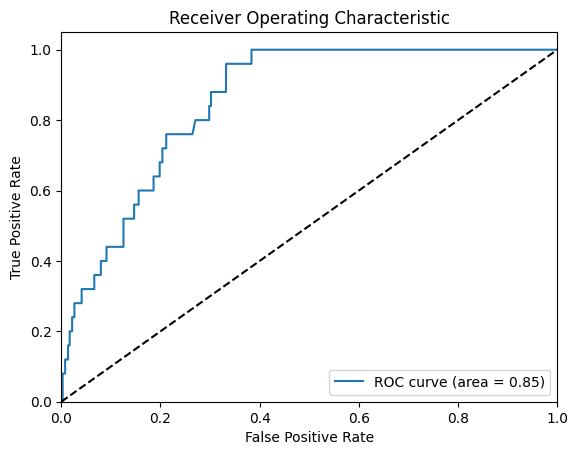


XGboost
Accuracy: 0.9526600541027953
Recall: 0.32
Precision: 0.08333333333333333
AUC-ROC: 0.8631737346101231
MCC: 0.1451914235435072


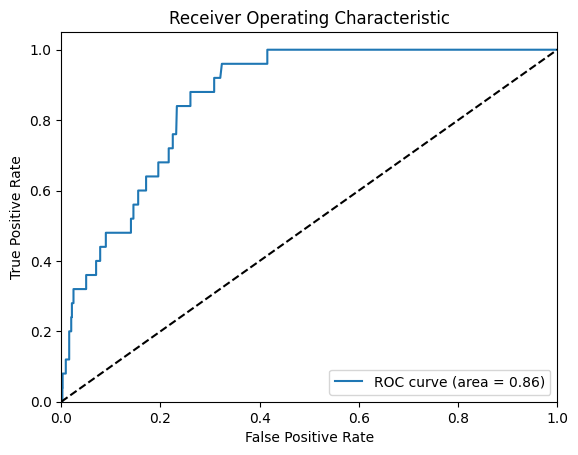


Neural Network
Epoch [1/500], Loss: 0.7059
Epoch [2/500], Loss: 0.6885
Epoch [3/500], Loss: 0.6725
Epoch [4/500], Loss: 0.6578
Epoch [5/500], Loss: 0.6443
Epoch [6/500], Loss: 0.6314
Epoch [7/500], Loss: 0.6205
Epoch [8/500], Loss: 0.6108
Epoch [9/500], Loss: 0.6020
Epoch [10/500], Loss: 0.5938
Epoch [11/500], Loss: 0.5867
Epoch [12/500], Loss: 0.5808
Epoch [13/500], Loss: 0.5759
Epoch [14/500], Loss: 0.5720
Epoch [15/500], Loss: 0.5690
Epoch [16/500], Loss: 0.5667
Epoch [17/500], Loss: 0.5650
Epoch [18/500], Loss: 0.5639
Epoch [19/500], Loss: 0.5632
Epoch [20/500], Loss: 0.5627
Epoch [21/500], Loss: 0.5623
Epoch [22/500], Loss: 0.5620
Epoch [23/500], Loss: 0.5617
Epoch [24/500], Loss: 0.5613
Epoch [25/500], Loss: 0.5608
Epoch [26/500], Loss: 0.5603
Epoch [27/500], Loss: 0.5596
Epoch [28/500], Loss: 0.5589
Epoch [29/500], Loss: 0.5580
Epoch [30/500], Loss: 0.5572
Epoch [31/500], Loss: 0.5563
Epoch [32/500], Loss: 0.5554
Epoch [33/500], Loss: 0.5544
Epoch [34/500], Loss: 0.5535
Epoch [

Epoch [279/500], Loss: 0.4680
Epoch [280/500], Loss: 0.4678
Epoch [281/500], Loss: 0.4677
Epoch [282/500], Loss: 0.4676
Epoch [283/500], Loss: 0.4674
Epoch [284/500], Loss: 0.4673
Epoch [285/500], Loss: 0.4672
Epoch [286/500], Loss: 0.4670
Epoch [287/500], Loss: 0.4669
Epoch [288/500], Loss: 0.4668
Epoch [289/500], Loss: 0.4666
Epoch [290/500], Loss: 0.4665
Epoch [291/500], Loss: 0.4663
Epoch [292/500], Loss: 0.4662
Epoch [293/500], Loss: 0.4661
Epoch [294/500], Loss: 0.4659
Epoch [295/500], Loss: 0.4658
Epoch [296/500], Loss: 0.4656
Epoch [297/500], Loss: 0.4655
Epoch [298/500], Loss: 0.4654
Epoch [299/500], Loss: 0.4652
Epoch [300/500], Loss: 0.4651
Epoch [301/500], Loss: 0.4649
Epoch [302/500], Loss: 0.4647
Epoch [303/500], Loss: 0.4646
Epoch [304/500], Loss: 0.4644
Epoch [305/500], Loss: 0.4642
Epoch [306/500], Loss: 0.4640
Epoch [307/500], Loss: 0.4638
Epoch [308/500], Loss: 0.4637
Epoch [309/500], Loss: 0.4635
Epoch [310/500], Loss: 0.4633
Epoch [311/500], Loss: 0.4631
Epoch [312

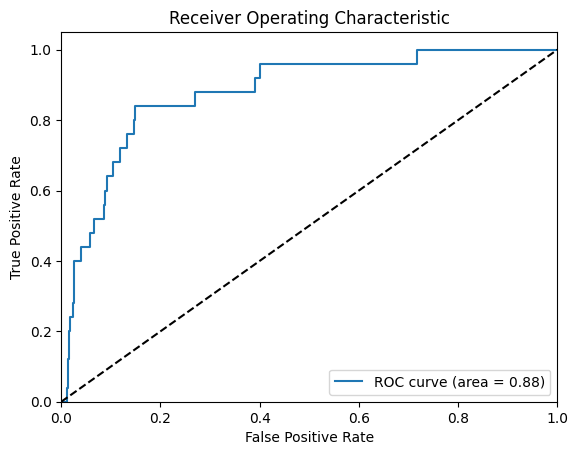

In [58]:
###Strategy 1, only embedding
#%matplotlib inline


from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, matthews_corrcoef, roc_curve, auc
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression


X_train = embed_train
X_test = embed_test
y_train = embed_label_train
y_test = embed_label_test

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

result = []

'''
# Example: Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_predictions = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)

print("Random Forest")
evaluate_model(y_test, rf_predictions, rf_proba)
print()
'''

lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)
lgbm_predictions = lgbm.predict(X_test)
lgbm_proba = lgbm.predict_proba(X_test)

print("LGBM")
evaluate_model(y_test, lgbm_predictions, lgbm_proba)
print()

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_proba = xgb_model.predict_proba(X_test)

print("XGboost")
evaluate_model(y_test, xgb_predictions, xgb_proba)
print()

'''
svm = SVC(probability=True)
calibrated_svm = CalibratedClassifierCV(svm)
calibrated_svm.fit(X_train, y_train)
svm_predictions = calibrated_svm.predict(X_test)
svm_proba = calibrated_svm.predict_proba(X_test)

print("SVM")
evaluate_model(y_test, svm_predictions, svm_proba)
print("SVM")
'''


#neural network

print("Neural Network")


scaler = StandardScaler()
X_train_np_scaled = scaler.fit_transform(X_train)
X_test_np_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_np_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Reshape for consistency with output
X_test_tensor = torch.tensor(X_test_np_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

model = SimpleNN(26)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.005)  # Using Adam optimizer

y_train_tensor = y_train_tensor.view(-1, 1)
y_test_tensor = y_test_tensor.view(-1, 1)

num_epochs = 500  # Number of training epochs

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    
    optimizer.zero_grad()  # Clear gradients
    outputs = model(X_train_tensor)  # Forward pass
    loss = criterion(outputs, y_train_tensor)  # Calculate loss
    loss.backward()  # Backward pass
    optimizer.step()  # Update weights
    
    # Print loss every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predictions = model(X_test_tensor)
    predicted_classes = torch.round(predictions).numpy()
    predicted_probs = predictions.numpy()
    probs = np.zeros((2218, 2))
    probs[:, 1] = predicted_probs[:, 0]
    
    print('Evaluation')
    evaluate_model(y_test_tensor, predicted_classes, probs)
    print()
    

In [72]:
from sklearn.model_selection import GridSearchCV

#XGboost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'n_estimators': [300, 500],
        'learning_rate': [0.05, 0.1]
}



Fitting 2 folds for each of 810 candidates, totalling 1620 fits
Best parameters: {'colsample_bytree': 1.0, 'gamma': 0.5, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.8}
Best score: 0.9926822856388035


In [120]:
tuning = []

i = 0
for mcw in params['min_child_weight']:
    for g in params['gamma']:
        for s in params['subsample']:
            for cb in params['colsample_bytree']:
                for d in params['max_depth']:
                    for e in params['n_estimators']:
                        for lr in params['learning_rate']:
                            
                            xgb_model = xgb.XGBClassifier(use_label_encoder=False, 
                              eval_metric='logloss',
                            colsample_bytree=cb,
                              gamma=g,
                             learning_rate=lr,
                             max_depth=d,
                             n_estimators=e,
                             subsample=s,
                             min_child_weight=mcw)
                            xgb_model.fit(X_train, y_train)
                            xgb_proba = xgb_model.predict_proba(X_test)

                            
                            auc_roc = roc_auc_score(y_test, xgb_proba[:, 1])
                            tuning.append({
                                'score': auc_roc,
            'min_child_weight': mcw,
            'gamma': g,
            'subsample': s,
            'colsample_bytree': cb,
            'max_depth': d,
            'n_estimators': e,
            'learning_rate': lr
    })
                            i += 1
                            print(i)
                        
tuning.sort(key=lambda x: x['score'])
                        

KeyError: 'gamma'

In [94]:
print(tuning)

[{'score': 0.8397355221158231, 'min_child_weight': 1, 'gamma': 2, 'subsample': 0.8, 'colsample_bytree': 1.0, 'max_depth': 3, 'n_estimators': 500, 'learning_rate': 0.05}, {'score': 0.8406475148198814, 'min_child_weight': 1, 'gamma': 1.5, 'subsample': 0.8, 'colsample_bytree': 1.0, 'max_depth': 3, 'n_estimators': 500, 'learning_rate': 0.05}, {'score': 0.8406748746010032, 'min_child_weight': 1, 'gamma': 1, 'subsample': 0.8, 'colsample_bytree': 1.0, 'max_depth': 3, 'n_estimators': 500, 'learning_rate': 0.05}, {'score': 0.841532147742818, 'min_child_weight': 1, 'gamma': 0.5, 'subsample': 0.6, 'colsample_bytree': 0.8, 'max_depth': 3, 'n_estimators': 500, 'learning_rate': 0.05}, {'score': 0.8417145462836297, 'min_child_weight': 1, 'gamma': 0.5, 'subsample': 0.8, 'colsample_bytree': 1.0, 'max_depth': 3, 'n_estimators': 500, 'learning_rate': 0.05}, {'score': 0.8417692658458733, 'min_child_weight': 1, 'gamma': 1.5, 'subsample': 0.6, 'colsample_bytree': 0.8, 'max_depth': 3, 'n_estimators': 500, 'l

XGboost
Accuracy: 0.9206492335437331
Recall: 0.48
Precision: 0.06857142857142857
AUC-ROC: 0.8911536707706338
MCC: 0.15885898459331593


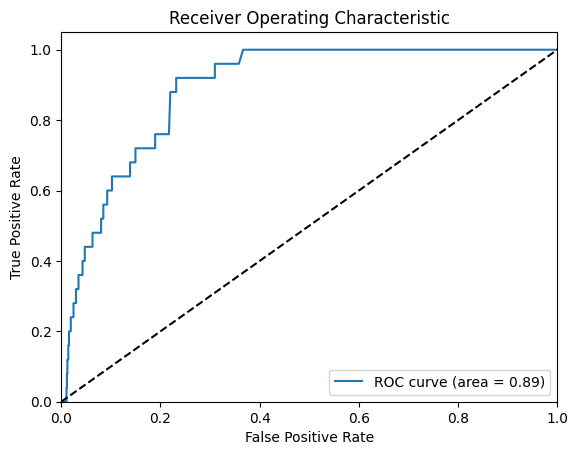


<bound method NDFrame._add_numeric_operations.<locals>.all of         Name  Probability
4909  Q15392     0.983997
1385  Q08828     0.979559
6140  P37058     0.978639
6849  O60353     0.978448
2993  Q13698     0.977164
...      ...          ...
5739  Q12815     0.004561
3346  Q53G59     0.004561
6195  Q7L4I2     0.004550
373   Q8N8B7     0.004550
1736  P11049     0.004538

[7309 rows x 2 columns]>


In [130]:


xgb_model = xgb.XGBClassifier(use_label_encoder=False, 
                              eval_metric='logloss',
                            colsample_bytree=1.0,
                              gamma=5,
                             learning_rate=0.05,
                             max_depth=11,
                             n_estimators=300,
                             subsample=0.6,
                             min_child_weight=10)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_proba = xgb_model.predict_proba(X_test)

print("XGboost")
evaluate_model(y_test, xgb_predictions, xgb_proba)
print()


final = embed.iloc[:7392, :26]

final_proba = xgb_model.predict_proba(final)
final_proba = final_proba[:, 1]
names = np.array(embed['protein_name'][:7392])

output = pd.DataFrame({
    "Name": names,
    "Probability": final_proba
})

output = output.sort_values(by="Probability", ascending=False)

csv_file_path = 'prediction_embedonly_xgboost.csv'
output.to_csv(csv_file_path, index=False)

my_list = ['P18507', 'P23416', 'P21918', 'P31513', 'P28472', 'P35367', 'O00591', 'P19838', 'P19634', 'P08908', 'P47869', 'Q00653', 'P18505', 'P31645', 'Q12809', 'P02768', 'P98066', 'P35348', 'P10635', 'P05067', 'Q12879', 'P08173', 'O15399', 'P14867', 'P20813', 'Q8N1C3', 'P47870', 'P08913', 'P06276', 'P21728', 'P14416', 'P35368', 'P24462', 'P46098', 'P31644', 'P20309', 'P11712', 'O14764', 'P08172', 'P20815', 'O60391', 'Q13224', 'P50406', 'P08588', 'P28566', 'Q14957', 'P22303', 'P35462', 'Q96FL8', 'Q9UNQ0', 'P25100', 'P28222', 'Q9UN88', 'P08684', 'P33261', 'P02763', 'P11229', 'P07550', 'P28223', 'O75311', 'Q9HB55', 'P21917', 'P48167', 'Q9H015', 'P22310', 'P28221', 'Q16445', 'P28335', 'P13945', 'P23415', 'P78334', 'P36544', 'P05177', 'P34903', 'P30939', 'Q99928', 'Q05586', 'P08183', 'P48169', 'Q8TCU5', 'P11509', 'P05181', 'P18089']

output = output[~output['Name'].isin(my_list)]
print(output.all)

csv_file_path = 'prediction_embedonly_xgboost_unknown.csv'
output.to_csv(csv_file_path, index=False)

In [127]:
#LighGBM

params = {
        'min_child_weight': [1, 5, 10],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [5, 8, 11],
        'n_estimators': [300, 500],
        'learning_rate': [0.05, 0.1],
        'num_leaves': [31, 127],
        'reg_alpha': [0.1, 0.5]
}



tuning = []

i = 0
for mcw in params['min_child_weight']:
    for a in params['reg_alpha']:
        for s in params['subsample']:
            for cb in params['colsample_bytree']:
                for d in params['max_depth']:
                    for e in params['n_estimators']:
                        for lr in params['learning_rate']:
                            for l in params['num_leaves']:
                            
                                xgb_model = LGBMClassifier(colsample_bytree=cb,
                                  reg_alpha=a,
                                 learning_rate=lr,
                                 max_depth=d,
                                 n_estimators=e,
                                 subsample=s,
                                 min_child_weight=mcw,
                                num_leaves=l, verbose = -1)
                                
                                
                                xgb_model.fit(X_train, y_train)
                                xgb_proba = xgb_model.predict_proba(X_test)


                                auc_roc = roc_auc_score(y_test, xgb_proba[:, 1])
                                tuning.append({
                                    'score': auc_roc,
                'min_child_weight': mcw,
                'reg_alpha': a,
                'subsample': s,
                'colsample_bytree': cb,
                'max_depth': d,
                'n_estimators': e,
                'learning_rate': lr,
                'num_leaves':l
        })
                                i += 1
                                print(i)
                        
tuning.sort(key=lambda x: x['score'])


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [128]:
print(tuning)

[{'score': 0.8350022799817601, 'min_child_weight': 5, 'reg_alpha': 0.5, 'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 11, 'n_estimators': 500, 'learning_rate': 0.1, 'num_leaves': 31}, {'score': 0.8350022799817601, 'min_child_weight': 5, 'reg_alpha': 0.5, 'subsample': 0.8, 'colsample_bytree': 0.6, 'max_depth': 11, 'n_estimators': 500, 'learning_rate': 0.1, 'num_leaves': 31}, {'score': 0.8350022799817601, 'min_child_weight': 5, 'reg_alpha': 0.5, 'subsample': 1.0, 'colsample_bytree': 0.6, 'max_depth': 11, 'n_estimators': 500, 'learning_rate': 0.1, 'num_leaves': 31}, {'score': 0.8354856361149111, 'min_child_weight': 5, 'reg_alpha': 0.1, 'subsample': 0.6, 'colsample_bytree': 1.0, 'max_depth': 11, 'n_estimators': 500, 'learning_rate': 0.1, 'num_leaves': 31}, {'score': 0.8354856361149111, 'min_child_weight': 5, 'reg_alpha': 0.1, 'subsample': 0.8, 'colsample_bytree': 1.0, 'max_depth': 11, 'n_estimators': 500, 'learning_rate': 0.1, 'num_leaves': 31}, {'score': 0.8354856361149111, 'min

XGboost
Accuracy: 0.954463480613165
Recall: 0.32
Precision: 0.08695652173913043
AUC-ROC: 0.8720018239854082
MCC: 0.1491402713801789


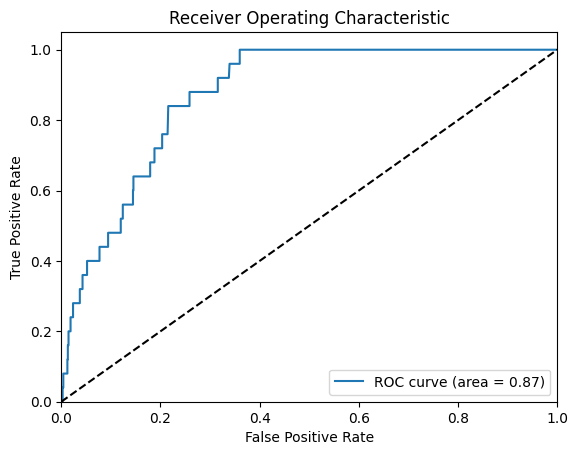


<bound method NDFrame._add_numeric_operations.<locals>.all of         Name  Probability
6140  P37058     0.997288
769   Q16678     0.996947
1521  Q96NR8     0.995068
1385  Q08828     0.992897
5668  P35503     0.992172
...      ...          ...
5936  O60759     0.000015
6948  Q9BQG2     0.000014
5506  Q96T68     0.000014
5138  Q9UJA5     0.000012
6251  P09923     0.000012

[7309 rows x 2 columns]>


In [131]:
xgb_model = LGBMClassifier(colsample_bytree=1,
                                  reg_alpha=0.5,
                                 learning_rate=0.05,
                                 max_depth=8,
                                 n_estimators=300,
                                 subsample=1,
                                 min_child_weight=1,
                                num_leaves=127, verbose = -1)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_proba = xgb_model.predict_proba(X_test)

print("XGboost")
evaluate_model(y_test, xgb_predictions, xgb_proba)
print()


final = embed.iloc[:7392, :26]

final_proba = xgb_model.predict_proba(final)
final_proba = final_proba[:, 1]
names = np.array(embed['protein_name'][:7392])

output = pd.DataFrame({
    "Name": names,
    "Probability": final_proba
})

output = output.sort_values(by="Probability", ascending=False)

csv_file_path = 'prediction_embedonly_LightGBM.csv'
output.to_csv(csv_file_path, index=False)

my_list = ['P18507', 'P23416', 'P21918', 'P31513', 'P28472', 'P35367', 'O00591', 'P19838', 'P19634', 'P08908', 'P47869', 'Q00653', 'P18505', 'P31645', 'Q12809', 'P02768', 'P98066', 'P35348', 'P10635', 'P05067', 'Q12879', 'P08173', 'O15399', 'P14867', 'P20813', 'Q8N1C3', 'P47870', 'P08913', 'P06276', 'P21728', 'P14416', 'P35368', 'P24462', 'P46098', 'P31644', 'P20309', 'P11712', 'O14764', 'P08172', 'P20815', 'O60391', 'Q13224', 'P50406', 'P08588', 'P28566', 'Q14957', 'P22303', 'P35462', 'Q96FL8', 'Q9UNQ0', 'P25100', 'P28222', 'Q9UN88', 'P08684', 'P33261', 'P02763', 'P11229', 'P07550', 'P28223', 'O75311', 'Q9HB55', 'P21917', 'P48167', 'Q9H015', 'P22310', 'P28221', 'Q16445', 'P28335', 'P13945', 'P23415', 'P78334', 'P36544', 'P05177', 'P34903', 'P30939', 'Q99928', 'Q05586', 'P08183', 'P48169', 'Q8TCU5', 'P11509', 'P05181', 'P18089']

output = output[~output['Name'].isin(my_list)]
print(output.all)

csv_file_path = 'prediction_embedonly_LightGBM_unknown.csv'
output.to_csv(csv_file_path, index=False)

In [142]:
#Neural Network!!

ln = [1, 13, 26, 52, 64, 80, 100]
epochs_gen = [200, 300, 400, 500, 600, 700, 800, 1000]
lr = [0.005, 0.01, 0.05, 0.1]
ans = []
for l1 in ln:
    for epoch_ in epochs_gen:
        for r in lr:

            model = SimpleNN(26, l1)
            criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
            optimizer = optim.Adam(model.parameters(), lr=r)  # Using Adam optimizer

            y_train_tensor = y_train_tensor.view(-1, 1)
            y_test_tensor = y_test_tensor.view(-1, 1)
  # Number of training epochs

            for epoch in range(epoch_):
                model.train()  # Set model to training mode

                optimizer.zero_grad()  # Clear gradients
                outputs = model(X_train_tensor)  # Forward pass
                loss = criterion(outputs, y_train_tensor)  # Calculate loss
                loss.backward()  # Backward pass
                optimizer.step()  # Update weights

                # Print loss every epoch
                #print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

            model.eval()  # Set the model to evaluation mode
            with torch.no_grad():
                predictions = model(X_test_tensor)
                predicted_classes = torch.round(predictions).numpy()
                predicted_probs = predictions.numpy()
                probs = np.zeros((2218, 2))
                probs[:, 1] = predicted_probs[:, 0]

                auc_roc = roc_auc_score(y_test, probs[:, 1])
                
            print(auc_roc)
            ans.append({'score':auc_roc, 'num_epochs': epoch_, 'mid_layer': l1, 'learning_rate':r})

0.6430278157774737
0.6459644322845417
0.6483538531691746
0.6480620155038759
0.8187779297765617
0.6482808937528499
0.6482626538987688
0.8860373917008665
0.6464021887824897
0.6486456908344732
0.8728864569083447
0.8867669858641131
0.821906064751482
0.8832102143182854
0.8878796169630643
0.860501595987232
0.6477336981304149
0.6483720930232557
0.6508891928864569
0.8943365253077977
0.6480255357957135
0.6480802553579571
0.8622708618331053
0.6514546283629731
0.8251892384860922
0.647533059735522
0.8629274965800274
0.6342726858185135
0.6485362517099862
0.8790697674418604
0.8639580483356133
0.6349293205654355
0.8337072503419972
0.8485909712722298
0.8606839945280438
0.81984496124031
0.8420337437300502
0.8601550387596899
0.8108891928864569
0.8364614683082536
0.8601003191974465
0.8525398996808026
0.7932147742818058
0.8571819425444597
0.8786502507979935
0.8920747834017327
0.8363885088919288
0.7868308253533972
0.8527222982216143
0.8330232558139534
0.7933059735522116
0.8355677154582763
0.840291837665298

In [143]:
ans.sort(key=lambda x: x['score'])
print(ans)

[{'score': 0.6342726858185135, 'num_epochs': 800, 'mid_layer': 1, 'learning_rate': 0.1}, {'score': 0.6349293205654355, 'num_epochs': 1000, 'mid_layer': 1, 'learning_rate': 0.1}, {'score': 0.6430278157774737, 'num_epochs': 200, 'mid_layer': 1, 'learning_rate': 0.005}, {'score': 0.6459644322845417, 'num_epochs': 200, 'mid_layer': 1, 'learning_rate': 0.01}, {'score': 0.6464021887824897, 'num_epochs': 400, 'mid_layer': 1, 'learning_rate': 0.005}, {'score': 0.647533059735522, 'num_epochs': 800, 'mid_layer': 1, 'learning_rate': 0.01}, {'score': 0.6477336981304149, 'num_epochs': 600, 'mid_layer': 1, 'learning_rate': 0.005}, {'score': 0.6480255357957135, 'num_epochs': 700, 'mid_layer': 1, 'learning_rate': 0.005}, {'score': 0.6480620155038759, 'num_epochs': 200, 'mid_layer': 1, 'learning_rate': 0.1}, {'score': 0.6480802553579571, 'num_epochs': 700, 'mid_layer': 1, 'learning_rate': 0.01}, {'score': 0.6482626538987688, 'num_epochs': 300, 'mid_layer': 1, 'learning_rate': 0.05}, {'score': 0.6482808

In [ ]:
###Strategy 2, only features

Random Forest
Accuracy: 0.9882777276825969
Recall: 0.28
Precision: 0.4666666666666667
AUC-ROC: 0.8845052439580483
MCC: 0.3559582802752483


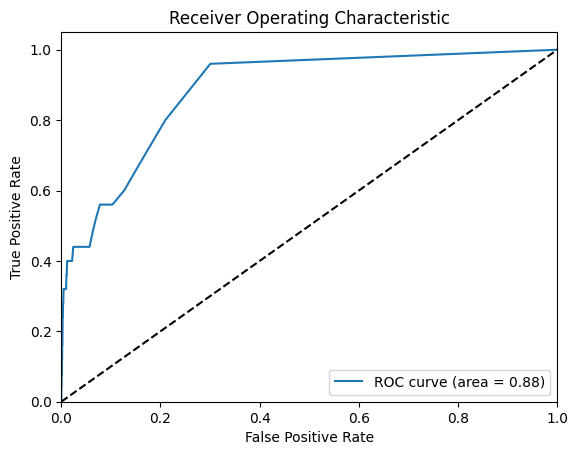


[LightGBM] [Info] Number of positive: 5115, number of negative: 5115
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11784
[LightGBM] [Info] Number of data points in the train set: 10230, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LGBM
Accuracy: 0.9896302975653742
Recall: 0.32
Precision: 0.5714285714285714
AUC-ROC: 0.8716643866849065
MCC: 0.42290257803430814


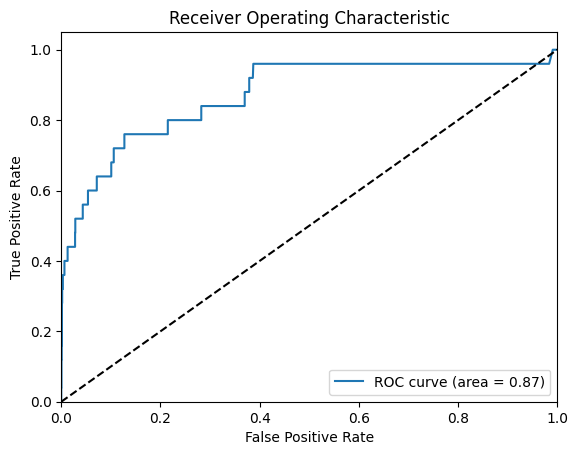


XGboost
Accuracy: 0.9896302975653742
Recall: 0.28
Precision: 0.5833333333333334
AUC-ROC: 0.8828636570907433
MCC: 0.3996714519223473


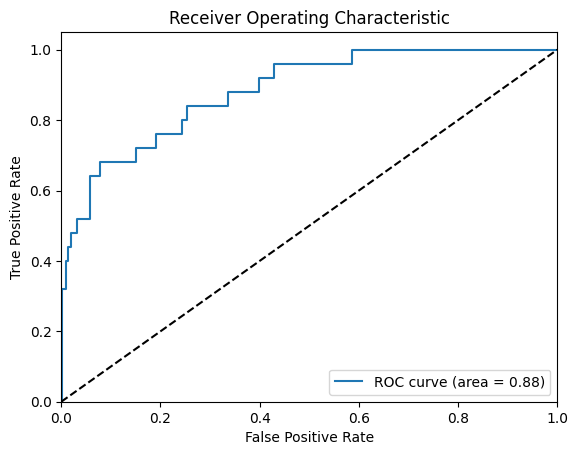


SVM
Accuracy: 0.9752028854824166
Recall: 0.04
Precision: 0.03125
AUC-ROC: 0.680766073871409
MCC: 0.022897435414671118


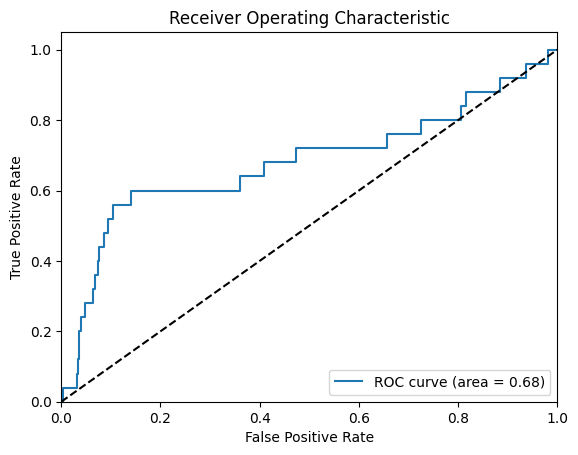

SVM
Neural Network
Epoch [1/500], Loss: 0.7382
Epoch [2/500], Loss: 0.6866
Epoch [3/500], Loss: 0.6437
Epoch [4/500], Loss: 0.6073
Epoch [5/500], Loss: 0.5757
Epoch [6/500], Loss: 0.5481
Epoch [7/500], Loss: 0.5242
Epoch [8/500], Loss: 0.5033
Epoch [9/500], Loss: 0.4853
Epoch [10/500], Loss: 0.4699
Epoch [11/500], Loss: 0.4569
Epoch [12/500], Loss: 0.4458
Epoch [13/500], Loss: 0.4362
Epoch [14/500], Loss: 0.4278
Epoch [15/500], Loss: 0.4200
Epoch [16/500], Loss: 0.4124
Epoch [17/500], Loss: 0.4047
Epoch [18/500], Loss: 0.3969
Epoch [19/500], Loss: 0.3887
Epoch [20/500], Loss: 0.3803
Epoch [21/500], Loss: 0.3717
Epoch [22/500], Loss: 0.3630
Epoch [23/500], Loss: 0.3544
Epoch [24/500], Loss: 0.3458
Epoch [25/500], Loss: 0.3375
Epoch [26/500], Loss: 0.3294
Epoch [27/500], Loss: 0.3217
Epoch [28/500], Loss: 0.3142
Epoch [29/500], Loss: 0.3070
Epoch [30/500], Loss: 0.3000
Epoch [31/500], Loss: 0.2932
Epoch [32/500], Loss: 0.2866
Epoch [33/500], Loss: 0.2803
Epoch [34/500], Loss: 0.2742
Epoc

Epoch [281/500], Loss: 0.0495
Epoch [282/500], Loss: 0.0494
Epoch [283/500], Loss: 0.0492
Epoch [284/500], Loss: 0.0490
Epoch [285/500], Loss: 0.0489
Epoch [286/500], Loss: 0.0487
Epoch [287/500], Loss: 0.0485
Epoch [288/500], Loss: 0.0484
Epoch [289/500], Loss: 0.0482
Epoch [290/500], Loss: 0.0480
Epoch [291/500], Loss: 0.0479
Epoch [292/500], Loss: 0.0477
Epoch [293/500], Loss: 0.0475
Epoch [294/500], Loss: 0.0474
Epoch [295/500], Loss: 0.0472
Epoch [296/500], Loss: 0.0470
Epoch [297/500], Loss: 0.0469
Epoch [298/500], Loss: 0.0467
Epoch [299/500], Loss: 0.0466
Epoch [300/500], Loss: 0.0464
Epoch [301/500], Loss: 0.0462
Epoch [302/500], Loss: 0.0461
Epoch [303/500], Loss: 0.0459
Epoch [304/500], Loss: 0.0458
Epoch [305/500], Loss: 0.0456
Epoch [306/500], Loss: 0.0454
Epoch [307/500], Loss: 0.0453
Epoch [308/500], Loss: 0.0451
Epoch [309/500], Loss: 0.0450
Epoch [310/500], Loss: 0.0448
Epoch [311/500], Loss: 0.0447
Epoch [312/500], Loss: 0.0445
Epoch [313/500], Loss: 0.0444
Epoch [314

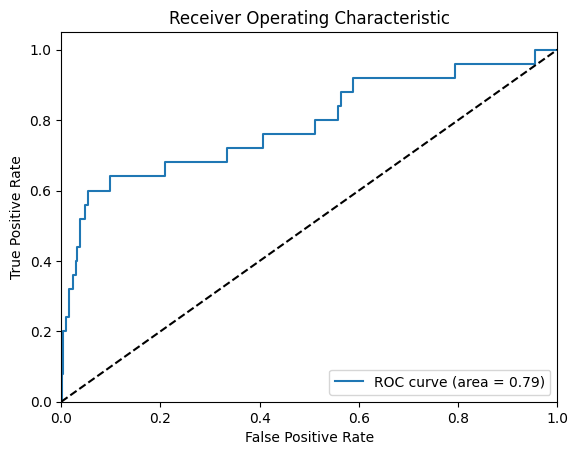

In [151]:
###Strategy 3, both concatenating




from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, matthews_corrcoef, roc_curve, auc
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression


X_train = np.concatenate((embed_train, featu_train), axis=1)

X_test =  np.concatenate((embed_test, featu_test), axis=1)

y_train = embed_label_train
y_test = embed_label_test

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

result = []

'''
# Example: Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_predictions = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)

print("Random Forest")
evaluate_model(y_test, rf_predictions, rf_proba)
print()
'''

lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)
lgbm_predictions = lgbm.predict(X_test)
lgbm_proba = lgbm.predict_proba(X_test)

print("LGBM")
evaluate_model(y_test, lgbm_predictions, lgbm_proba)
print()

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_proba = xgb_model.predict_proba(X_test)

print("XGboost")
evaluate_model(y_test, xgb_predictions, xgb_proba)
print()

'''
svm = SVC(probability=True)
calibrated_svm = CalibratedClassifierCV(svm)
calibrated_svm.fit(X_train, y_train)
svm_predictions = calibrated_svm.predict(X_test)
svm_proba = calibrated_svm.predict_proba(X_test)

print("SVM")
evaluate_model(y_test, svm_predictions, svm_proba)
print("SVM")
'''


#neural network

print("Neural Network")


scaler = StandardScaler()
X_train_np_scaled = scaler.fit_transform(X_train)
X_test_np_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_np_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Reshape for consistency with output
X_test_tensor = torch.tensor(X_test_np_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

model = SimpleNN(52, 26)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.005)  # Using Adam optimizer

y_train_tensor = y_train_tensor.view(-1, 1)
y_test_tensor = y_test_tensor.view(-1, 1)

num_epochs = 500  # Number of training epochs

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    
    optimizer.zero_grad()  # Clear gradients
    outputs = model(X_train_tensor)  # Forward pass
    loss = criterion(outputs, y_train_tensor)  # Calculate loss
    loss.backward()  # Backward pass
    optimizer.step()  # Update weights
    
    # Print loss every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predictions = model(X_test_tensor)
    predicted_classes = torch.round(predictions).numpy()
    predicted_probs = predictions.numpy()
    probs = np.zeros((2218, 2))
    probs[:, 1] = predicted_probs[:, 0]
    
    print('Evaluation')
    evaluate_model(y_test_tensor, predicted_classes, probs)
    print()
    


In [152]:
##lightGBM hyperparameter tuning

params = {
        'min_child_weight': [1, 5, 10],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [5, 8, 11],
        'n_estimators': [300, 500],
        'learning_rate': [0.05, 0.1],
        'num_leaves': [31, 127],
        'reg_alpha': [0.1, 0.5]
}



tuning = []

i = 0
for mcw in params['min_child_weight']:
    for a in params['reg_alpha']:
        for s in params['subsample']:
            for cb in params['colsample_bytree']:
                for d in params['max_depth']:
                    for e in params['n_estimators']:
                        for lr in params['learning_rate']:
                            for l in params['num_leaves']:
                            
                                xgb_model = LGBMClassifier(colsample_bytree=cb,
                                  reg_alpha=a,
                                 learning_rate=lr,
                                 max_depth=d,
                                 n_estimators=e,
                                 subsample=s,
                                 min_child_weight=mcw,
                                num_leaves=l, verbose = -1)
                                
                                
                                xgb_model.fit(X_train, y_train)
                                xgb_proba = xgb_model.predict_proba(X_test)


                                auc_roc = roc_auc_score(y_test, xgb_proba[:, 1])
                                tuning.append({
                                    'score': auc_roc,
                'min_child_weight': mcw,
                'reg_alpha': a,
                'subsample': s,
                'colsample_bytree': cb,
                'max_depth': d,
                'n_estimators': e,
                'learning_rate': lr,
                'num_leaves':l
        })
                                i += 1
                                print(i)
                        
tuning.sort(key=lambda x: x['score'])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [153]:
print(tuning)

[{'score': 0.8376288189694482, 'min_child_weight': 5, 'reg_alpha': 0.1, 'subsample': 0.6, 'colsample_bytree': 1.0, 'max_depth': 11, 'n_estimators': 300, 'learning_rate': 0.1, 'num_leaves': 127}, {'score': 0.8376288189694482, 'min_child_weight': 5, 'reg_alpha': 0.1, 'subsample': 0.8, 'colsample_bytree': 1.0, 'max_depth': 11, 'n_estimators': 300, 'learning_rate': 0.1, 'num_leaves': 127}, {'score': 0.8376288189694482, 'min_child_weight': 5, 'reg_alpha': 0.1, 'subsample': 1.0, 'colsample_bytree': 1.0, 'max_depth': 11, 'n_estimators': 300, 'learning_rate': 0.1, 'num_leaves': 127}, {'score': 0.8397446420428636, 'min_child_weight': 5, 'reg_alpha': 0.1, 'subsample': 0.6, 'colsample_bytree': 1.0, 'max_depth': 11, 'n_estimators': 500, 'learning_rate': 0.1, 'num_leaves': 127}, {'score': 0.8397446420428636, 'min_child_weight': 5, 'reg_alpha': 0.1, 'subsample': 0.8, 'colsample_bytree': 1.0, 'max_depth': 11, 'n_estimators': 500, 'learning_rate': 0.1, 'num_leaves': 127}, {'score': 0.8397446420428636,